In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [3]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [4]:
train_data_dir = 'data/tc4tl_training_data_v1/tc4tl/data/train/'
train_key = pd.read_csv('data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv', sep='\t')

## Helper functions

In [5]:
def read_bluetooth_from_file(filepath):
    """Read bluetooth RSSI readings from file"""
    return pd.DataFrame([ { 'Time' : float(line.split(',')[0]), 'Rssi' : float(line.split(',')[-1]) }
              for line in open(filepath).read().split('\n')
              if 'Bluetooth' in line ])

In [6]:
def chirp_sequence(df):
    """Return a sequence of values containing average RSSI reading of each chirp"""
    chirps, rssi = [], []
    for idx, t in df.iterrows():
        if idx > 0 and t.Time - df.Time.loc[idx - 1] > 1:
            chirps.append(np.array(rssi).mean())
            rssi = []
        else:
            rssi.append(-t.Rssi)
    return chirps + [np.array(rssi).mean(), ]

In [7]:
train_key

,fileid,phone_carriage_state,distance_in_meters,step_size_in_sec,coarse_grain
0,aaadbuvp_tc4tl20.csv,pocket_hand,1.8,50,Y
1,aaamkcii_tc4tl20.csv,pocket_pocket,3.0,80,N
2,aabqtowt_tc4tl20.csv,hand_hand,1.2,60,N
3,aadkjwss_tc4tl20.csv,pocket_pocket,1.8,20,N
4,aafzrgzt_tc4tl20.csv,hand_hand,1.8,60,Y
...,...,...,...,...,...
15547,zzwcoemu_tc4tl20.csv,pocket_hand,1.2,80,N
15548,zzwoqxuc_tc4tl20.csv,hand_hand,4.5,70,N
15549,zzymwbbb_tc4tl20.csv,pocket_pocket,1.2,10,N
15550,zzzflikz_tc4tl20.csv,hand_hand,1.8,100,Y


## Calculate Mean Chirp Sequences across training set

In [8]:
chirps = {}
for idx, row in tqdm(train_key[train_key.coarse_grain == 'Y'].iterrows()):
    df = read_bluetooth_from_file(os.path.join(train_data_dir, row.fileid))
    chirps[row.fileid] = chirp_sequence(df)

231it [00:35,  6.66it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
529it [01:25,  7.67it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
5184it [12:41,  6.81it/s]


## Pad Chirp Sequence

In [10]:
mean_chirp_seq = []

In [11]:
maxlen = max([len(v) for v in chirps.values()])

In [12]:
X, y = [], []
for fileid, seq in tqdm(chirps.items()):
    if np.isnan(seq).sum() == 0:
        _y = train_key[train_key.fileid == fileid].distance_in_meters.item()
        y.append(str(_y))
        x = seq + [0]*(maxlen - len(seq))
        X.append(x)
        chirp_seq_entry = {
            'fileid' : fileid,
            'distance': _y,
        }
        chirp_seq_entry.update({
            f'Rssi{i}' : xi for i, xi in enumerate(x)
        })
        mean_chirp_seq.append(chirp_seq_entry)

100%|██████████| 5184/5184 [00:06<00:00, 801.42it/s]


### Save Mean Chirp Sequence data to disk

In [13]:
mean_chirp_seq = pd.DataFrame(mean_chirp_seq)
mean_chirp_seq

,fileid,distance,Rssi0,Rssi1,Rssi2,Rssi3,Rssi4,Rssi5,Rssi6,Rssi7,...,Rssi36,Rssi37,Rssi38,Rssi39,Rssi40,Rssi41,Rssi42,Rssi43,Rssi44,Rssi45
0,aaadbuvp_tc4tl20.csv,1.8,57.108571,59.551515,66.778481,54.696429,53.888060,68.899371,65.414966,59.243523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aafzrgzt_tc4tl20.csv,1.8,57.166667,56.482759,53.840000,57.208333,48.000000,57.531250,58.969697,58.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aahiguvq_tc4tl20.csv,4.5,58.746269,60.834586,67.944056,65.708955,67.562092,61.825503,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aajxgoxc_tc4tl20.csv,4.5,51.581250,55.675978,53.598592,55.210843,57.668605,52.848837,59.237805,61.412903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aaksdobg_tc4tl20.csv,1.8,57.514620,64.693750,61.047904,57.160494,64.921788,61.232143,67.146497,55.247312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5121,zzmevjii_tc4tl20.csv,1.8,58.100457,75.516588,60.901961,77.383721,58.535294,64.183544,74.470297,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5122,zzmigogk_tc4tl20.csv,4.5,56.027586,55.228571,60.699115,56.668919,54.272059,53.224490,52.551724,51.022059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5123,zzplqfsh_tc4tl20.csv,4.5,64.255639,61.352113,61.580952,67.437500,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5124,zztjapcz_tc4tl20.csv,4.5,65.241379,70.500000,64.457831,69.873418,68.468750,76.114583,67.666667,74.096386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
mean_chirp_seq.to_csv('data/processed/cg.mean_chirp_sequence.train.csv', index=False)

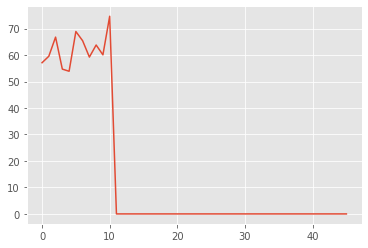

In [18]:
plt.plot(X[0])

In [20]:
y[0]

'1.8'

## Fit a Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
ypred = rf.predict(X_test)

In [45]:
from sklearn.metrics import classification_report


print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         1.8       0.93      0.97      0.95       779
         4.5       0.97      0.92      0.94       759

    accuracy                           0.95      1538
   macro avg       0.95      0.95      0.95      1538
weighted avg       0.95      0.95      0.95      1538



# Fine-Grained 

In [21]:
chirps_fg = {}
for idx, row in tqdm(train_key[train_key.coarse_grain == 'N'].iterrows()):
    df = read_bluetooth_from_file(os.path.join(train_data_dir, row.fileid))
    chirps_fg[row.fileid] = chirp_sequence(df)

545it [00:42, 14.78it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
10368it [13:22, 12.92it/s]


## Pad Chirp Sequence (FG)

In [23]:
mean_chirp_seq_fg = []

In [24]:
maxlen = max([len(v) for v in chirps_fg.values()])
maxlen

25

In [25]:
X_fg, y_fg = [], []
for fileid, seq in tqdm(chirps_fg.items()):
    if np.isnan(seq).sum() == 0:
        _y = train_key[train_key.fileid == fileid].distance_in_meters.item()
        y_fg.append(str(_y))
        x = seq + [0]*(maxlen - len(seq))
        X_fg.append(x)
        chirp_seq_entry = {
            'fileid' : fileid,
            'distance': _y,
        }
        chirp_seq_entry.update({
            f'Rssi{i}' : xi for i, xi in enumerate(x)
        })
        mean_chirp_seq_fg.append(chirp_seq_entry)

100%|██████████| 10368/10368 [00:12<00:00, 807.99it/s]


In [32]:
mean_chirp_seq_fg = pd.DataFrame(mean_chirp_seq_fg)
mean_chirp_seq_fg.to_csv('data/processed/fg.mean_chirp_sequence.train.csv', index=False)

In [31]:
mean_chirp_seq_fg

,fileid,distance,Rssi0,Rssi1,Rssi2,Rssi3,Rssi4,Rssi5,Rssi6,Rssi7,...,Rssi15,Rssi16,Rssi17,Rssi18,Rssi19,Rssi20,Rssi21,Rssi22,Rssi23,Rssi24
0,aaamkcii_tc4tl20.csv,3.0,49.692308,59.250000,62.500000,57.631579,54.800000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aabqtowt_tc4tl20.csv,1.2,52.284916,75.274194,55.357576,64.614035,62.836957,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aadkjwss_tc4tl20.csv,1.8,64.377246,62.309091,67.566667,62.543750,76.626582,62.582192,64.437500,69.129412,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aagsvrpi_tc4tl20.csv,4.5,51.871795,58.312883,63.537143,56.343750,53.300000,57.576471,63.051948,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aajtgeuo_tc4tl20.csv,3.0,64.134831,67.742515,57.816092,69.408537,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10304,zztzsbtt_tc4tl20.csv,1.8,58.988372,58.568807,60.793814,55.989474,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10305,zzwcoemu_tc4tl20.csv,1.2,58.988095,66.542169,54.675159,72.627586,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10306,zzwoqxuc_tc4tl20.csv,4.5,72.814516,81.229299,71.387931,80.931818,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10307,zzymwbbb_tc4tl20.csv,1.2,71.535088,64.310345,61.985507,62.943548,73.379562,84.640000,80.556391,77.909091,...,79.59322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


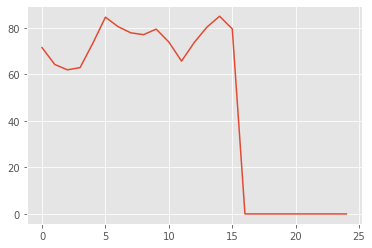

In [28]:
plt.plot(X_fg[-2])

In [30]:
y_fg[-2]

'1.2'

## Evaluation

In [71]:
X_train_fg, X_test_fg, y_train_fg, y_test_fg = train_test_split(X_fg, y_fg, test_size=0.3, random_state=69)
rf_fg = RandomForestClassifier()
rf_fg.fit(X_train_fg, y_train_fg)

RandomForestClassifier()

In [72]:
ypred_fg = rf_fg.predict(X_test_fg)

In [74]:
print(classification_report(y_test_fg, ypred_fg))

              precision    recall  f1-score   support

         1.2       0.85      0.91      0.88       794
         1.8       0.83      0.77      0.80       795
         3.0       0.82      0.82      0.82       730
         4.5       0.87      0.87      0.87       774

    accuracy                           0.84      3093
   macro avg       0.84      0.84      0.84      3093
weighted avg       0.84      0.84      0.84      3093



## Evaluation on Dev Set

In [20]:
from src.featutils import aggregate_features_from_folder
import src.features.baseline as fbase
from src.featutils import save_encoders

In [11]:
train_data_dir

'data/tc4tl_training_data_v1/tc4tl/data/train/'

In [12]:
trainset, encoders = aggregate_features_from_folder(train_data_dir, train_key,
                                                    feat_fn=fbase.extract_features_from_file,
                                                    postproc_fn=fbase.postproc_feature_dicts,
                                                    predictors=fbase.get_predictors,
                                                    target=fbase.TARGET
                                                   )

  4%|▍         | 623/15552 [01:06<29:34,  8.41it/s]/home/suriya/dcu/Group-Project/src/features/baseline.py:25: RuntimeWarning: Mean of empty slice.
  chirps.append(np.array(rssi).mean())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 868/15552 [01:32<20:01, 12.22it/s]/home/suriya/dcu/Group-Project/src/features/baseline.py:29: RuntimeWarning: Mean of empty slice.
  return chirps + [np.array(rssi).mean(), ]
100%|██████████| 15552/15552 [25:14<00:00, 10.27it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

In [18]:
trainset

,fileid,Rssi0,Rssi1,Rssi2,Rssi3,Rssi4,Rssi5,Rssi6,Rssi7,Rssi8,...,NormRssi38,NormRssi39,NormRssi40,NormRssi41,NormRssi42,NormRssi43,NormRssi44,NormRssi45,CoarseGrainEnc,Distance
0,aaadbuvp_tc4tl20.csv,57.108571,59.551515,66.778481,54.696429,53.888060,68.899371,65.414966,59.243523,63.800000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,1,1.8
1,aaamkcii_tc4tl20.csv,49.692308,59.250000,62.500000,57.631579,54.800000,0.000000,0.000000,0.000000,0.000000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,3.0
2,aabqtowt_tc4tl20.csv,52.284916,75.274194,55.357576,64.614035,62.836957,0.000000,0.000000,0.000000,0.000000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,1.2
3,aadkjwss_tc4tl20.csv,64.377246,62.309091,67.566667,62.543750,76.626582,62.582192,64.437500,69.129412,64.873494,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,1.8
4,aafzrgzt_tc4tl20.csv,57.166667,56.482759,53.840000,57.208333,48.000000,57.531250,58.969697,58.000000,60.852941,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,1,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,zzwcoemu_tc4tl20.csv,58.988095,66.542169,54.675159,72.627586,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,1.2
15548,zzwoqxuc_tc4tl20.csv,72.814516,81.229299,71.387931,80.931818,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,4.5
15549,zzymwbbb_tc4tl20.csv,71.535088,64.310345,61.985507,62.943548,73.379562,84.640000,80.556391,77.909091,77.119718,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0,1.2
15550,zzzflikz_tc4tl20.csv,57.909722,51.737705,73.278571,67.895833,61.019231,72.317881,0.000000,0.000000,0.000000,...,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,0.00297,1,1.8


In [21]:
trainset.to_csv('data/processed/baseline.trainset.csv', index=False)
save_encoders(encoders, "data/processed/baseline.encoders.bin")

In [53]:
dev_key = pd.read_csv('data/tc4tl_data_v5/tc4tl/docs/tc4tl_dev_key.tsv', sep='\t')
dev_data_dir = 'data/tc4tl_data_v5/tc4tl/data/dev/'
devset, devset_encoders = aggregate_features_from_folder(dev_data_dir, dev_key,
                               feat_fn=fbase.extract_features_from_file,
                               postproc_fn=fbase.postproc_feature_dicts,
                               predictors=fbase.get_predictors, target=fbase.TARGET,
                               encoders=encoders)
devset.to_csv('data/processed/baseline.devset.csv', index=False)

100%|██████████| 935/935 [01:27<00:00, 10.68it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [30]:
predictors = fbase.get_predictors(trainset)
predictors

['NormRssi0',
 'NormRssi1',
 'NormRssi2',
 'NormRssi3',
 'NormRssi4',
 'NormRssi5',
 'NormRssi6',
 'NormRssi7',
 'NormRssi8',
 'NormRssi9',
 'NormRssi10',
 'NormRssi11',
 'NormRssi12',
 'NormRssi13',
 'NormRssi14',
 'NormRssi15',
 'NormRssi16',
 'NormRssi17',
 'NormRssi18',
 'NormRssi19',
 'NormRssi20',
 'NormRssi21',
 'NormRssi22',
 'NormRssi23',
 'NormRssi24',
 'NormRssi25',
 'NormRssi26',
 'NormRssi27',
 'NormRssi28',
 'NormRssi29',
 'NormRssi30',
 'NormRssi31',
 'NormRssi32',
 'NormRssi33',
 'NormRssi34',
 'NormRssi35',
 'NormRssi36',
 'NormRssi37',
 'NormRssi38',
 'NormRssi39',
 'NormRssi40',
 'NormRssi41',
 'NormRssi42',
 'NormRssi43',
 'NormRssi44',
 'NormRssi45',
 'CoarseGrainEnc']

In [42]:
trainset_non_na = trainset[(trainset.isna().sum(axis=1) == 0)]

In [56]:
from src.featutils import pad_devset

devset_padded = pad_devset(devset, trainset)

In [58]:
from src.models.base import generate_submission_output

devset_system_output = generate_submission_output(trainset_non_na, devset_padded,predictors=predictors, target=fbase.TARGET)

In [60]:
!python3 evaluation/submission_scorer.py -o data/system_output/dev_system_output.tsv -l data/tc4tl_data_v5/tc4tl/docs/tc4tl_dev_trials.tsv -r data/tc4tl_data_v5/tc4tl/docs/tc4tl_dev_key.tsv

Subset		D	P_miss	P_fa	nDCF
fine_grain	1.20	0.61	0.08	0.70
fine_grain	1.80	0.41	0.16	0.58
fine_grain	3.00	0.33	0.35	0.69
coarse_grain	1.80	0.48	0.06	0.54


In [64]:
from src.models.base import fit_rf, evaluate

rf = fit_rf(trainset_non_na[predictors], trainset_non_na[fbase.TARGET])
report = evaluate(rf, devset[predictors], devset[fbase.TARGET])
print(report)

              precision    recall  f1-score   support

         1.2       0.60      0.39      0.47       153
         1.8       0.63      0.45      0.53       289
         3.0       0.49      0.42      0.45       175
         4.5       0.54      0.81      0.65       318

    accuracy                           0.56       935
   macro avg       0.56      0.52      0.52       935
weighted avg       0.57      0.56      0.54       935



## Evaluation on Unnormalized data

In [95]:
un_predictors = fbase.get_unnormalized_predictors(trainset_non_na)
trainset_unnormed = trainset_non_na[un_predictors + [fbase.TARGET]]

In [87]:
devset_un, devset_encoders = aggregate_features_from_folder(dev_data_dir, dev_key,
                               feat_fn=fbase.extract_features_from_file,
                               postproc_fn=fbase.postproc_feature_dicts,
                               predictors=fbase.get_unnormalized_predictors, target=fbase.TARGET,
                               encoders=encoders)

100%|██████████| 935/935 [01:29<00:00, 10.47it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [100]:
devset_un_padded = pad_devset(devset_un, trainset_unnormed)

In [101]:
devset_un_padded

,fileid,Rssi0,Rssi1,Rssi2,Rssi3,Rssi4,Rssi5,Rssi6,Rssi7,Rssi8,...,Rssi36,Rssi37,Rssi38,Rssi39,Rssi40,Rssi41,Rssi42,Rssi43,Rssi44,Rssi45
0,abgikaek_tc4tl20.csv,48.301587,61.935484,50.427350,55.613445,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acehqsss_tc4tl20.csv,57.944785,65.414966,73.496063,65.047619,65.144828,72.118056,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,adcmsfnp_tc4tl20.csv,58.882812,52.950820,63.323308,55.142857,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,adljjzjj_tc4tl20.csv,55.973333,69.573427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adzvqmmg_tc4tl20.csv,72.017467,64.677551,44.630000,59.342105,63.904762,62.304124,82.843137,64.257426,65.290541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,zuwuoron_tc4tl20.csv,58.492857,61.000000,64.507812,63.267717,60.992000,67.813008,62.440945,66.026786,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
931,zwixwixy_tc4tl20.csv,51.770492,59.283133,65.919255,72.681529,65.123596,63.319527,58.036810,77.025157,71.614035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,zzbtllni_tc4tl20.csv,48.654135,48.290598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,zzkjijcw_tc4tl20.csv,57.654971,68.415205,60.278409,78.029412,55.663212,57.387097,77.145570,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
devset_un.to_csv('data/processed/baseline.devset_unnormed.csv', index=False)

In [97]:
trainset_unnormed

,Rssi0,Rssi1,Rssi2,Rssi3,Rssi4,Rssi5,Rssi6,Rssi7,Rssi8,Rssi9,...,Rssi38,Rssi39,Rssi40,Rssi41,Rssi42,Rssi43,Rssi44,Rssi45,CoarseGrainEnc,Distance
0,57.108571,59.551515,66.778481,54.696429,53.888060,68.899371,65.414966,59.243523,63.800000,60.084337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.8
1,49.692308,59.250000,62.500000,57.631579,54.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0
2,52.284916,75.274194,55.357576,64.614035,62.836957,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.2
3,64.377246,62.309091,67.566667,62.543750,76.626582,62.582192,64.437500,69.129412,64.873494,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.8
4,57.166667,56.482759,53.840000,57.208333,48.000000,57.531250,58.969697,58.000000,60.852941,49.178571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,58.988095,66.542169,54.675159,72.627586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.2
15548,72.814516,81.229299,71.387931,80.931818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.5
15549,71.535088,64.310345,61.985507,62.943548,73.379562,84.640000,80.556391,77.909091,77.119718,79.504065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.2
15550,57.909722,51.737705,73.278571,67.895833,61.019231,72.317881,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.8


In [103]:
from src.models.base import fit_rf, evaluate

rf = fit_rf(trainset_unnormed[un_predictors], trainset_unnormed[fbase.TARGET])
report = evaluate(rf, devset_un_padded[un_predictors], devset_un[fbase.TARGET])
print(report)

              precision    recall  f1-score   support

         1.2       0.41      0.43      0.42       153
         1.8       0.41      0.42      0.41       289
         3.0       0.31      0.21      0.25       175
         4.5       0.51      0.58      0.54       318

    accuracy                           0.44       935
   macro avg       0.41      0.41      0.41       935
weighted avg       0.42      0.44      0.43       935



In [109]:
(devset_un[un_predictors] > 0).sum()

Rssi0             935
Rssi1             868
Rssi2             786
Rssi3             662
Rssi4             498
Rssi5             453
Rssi6             358
Rssi7             332
Rssi8             228
Rssi9             200
Rssi10            165
Rssi11            160
Rssi12            136
Rssi13            134
Rssi14            132
Rssi15            131
Rssi16             52
Rssi17             50
Rssi18             39
Rssi19             29
Rssi20             29
Rssi21             29
Rssi22             29
Rssi23             29
Rssi24             27
Rssi25             29
Rssi26             29
Rssi27             29
Rssi28             29
Rssi29             29
Rssi30             29
Rssi31             27
Rssi32              0
Rssi33              0
Rssi34              0
Rssi35              0
Rssi36              0
Rssi37              0
Rssi38              0
Rssi39              0
Rssi40              0
Rssi41              0
Rssi42              0
Rssi43              0
Rssi44              0
Rssi45    

In [107]:
(trainset[un_predictors] > 0).sum()

Rssi0             15552
Rssi1             15541
Rssi2             14665
Rssi3             13135
Rssi4              9900
Rssi5              8968
Rssi6              7416
Rssi7              6194
Rssi8              4447
Rssi9              4169
Rssi10             3946
Rssi11             3570
Rssi12             3012
Rssi13             2564
Rssi14             2305
Rssi15             2197
Rssi16              987
Rssi17              944
Rssi18              917
Rssi19              898
Rssi20              887
Rssi21              875
Rssi22              854
Rssi23              804
Rssi24              687
Rssi25              557
Rssi26              486
Rssi27              453
Rssi28              442
Rssi29              441
Rssi30              438
Rssi31              435
Rssi32               52
Rssi33               35
Rssi34               23
Rssi35               19
Rssi36               19
Rssi37               17
Rssi38               11
Rssi39               10
Rssi40                9
Rssi41          